# Project: Psychometric functions in CNNs

### Brief Project Description:

In this project, we are building a CNN that is able to simulate a psychometric function. A psychometric function maps the decision probability in binary classification studies when the stimuli are continuous. Specifically, we aim to simulate a psychometric function capable of deciding whether a given image contains a vertical or horizontal line.

To achieve this goal, we build a CNN model and train it on 1x30x30 images of Gaussian noise plus random vertical or horizontal lines (see the picture below). We then evaluate and plot our results.
<br/><br/>

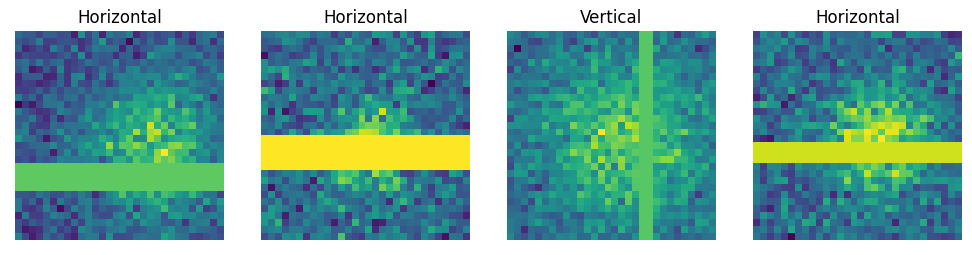
<br/><br/>


In a further step, we explore our previously trained model by subjecting it to new images. These images, of shape 1x30x30, differ from the training images because they have not only horizontal and vertical lines but also lines with a slope ranging from -30 to 30 (see the picture below). Next, we evaluate what is the predicted outcome on those images and plot again our results.
<br/><br/>

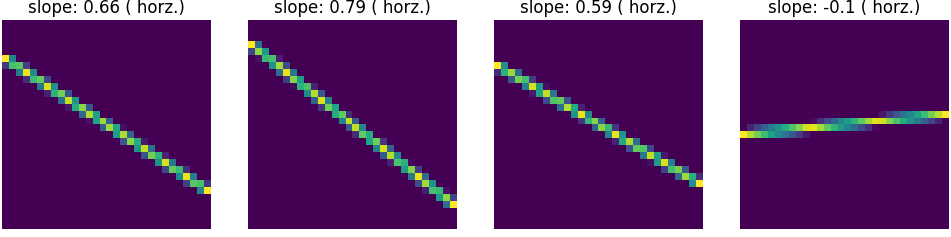



## Import Libraries

In [188]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import line_aa
import pandas as pd
import seaborn as sns

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split


## Create Train Images

In [190]:
# initialize gobal parameters
numberTrainImages = 1000
imageSize = 30

x = np.linspace(-4,4,imageSize)

# create a rectangular grid out of the array x
X,Y = np.meshgrid(x,x)

# vary the weights smoothly
width = np.linspace(2,20,numberTrainImages)

# initialize tensor containing the images
imagesTrain = torch.zeros(numberTrainImages, 1, imageSize,imageSize)

# initialize tensor containing the images labels
labelsTrain = torch.zeros(numberTrainImages,1) #.long()

# loop over every image
for i in range(numberTrainImages):

  # create the gaussian with random centers
  ro = 1.5*np.random.rand(2)
  gaussianImage = np.exp( -((X-ro[0])**2+(Y-ro[1])**2)/width[i])

  # add some noise to the gaussian image
  gaussianImage = gaussianImage + np.random.randn(imageSize, imageSize)/5

  # add a random bar
  i1 = np.random.choice(np.arange(2,28))
  i2 = np.random.choice(np.arange(2,6))

  # set a flagg
  flagg = random.randint(0, 1)

  if flagg:
    # create horizontal lines
    gaussianImage[i1:i1+i2] = 1
    labelsTrain[i] = 0

  else:
    # create vertical bars
    gaussianImage[:,i1:i1+i2] = 1
    labelsTrain[i] = 1

  # store the image
  imagesTrain[i,:,:,:] = torch.Tensor(gaussianImage).view(1,imageSize,imageSize)

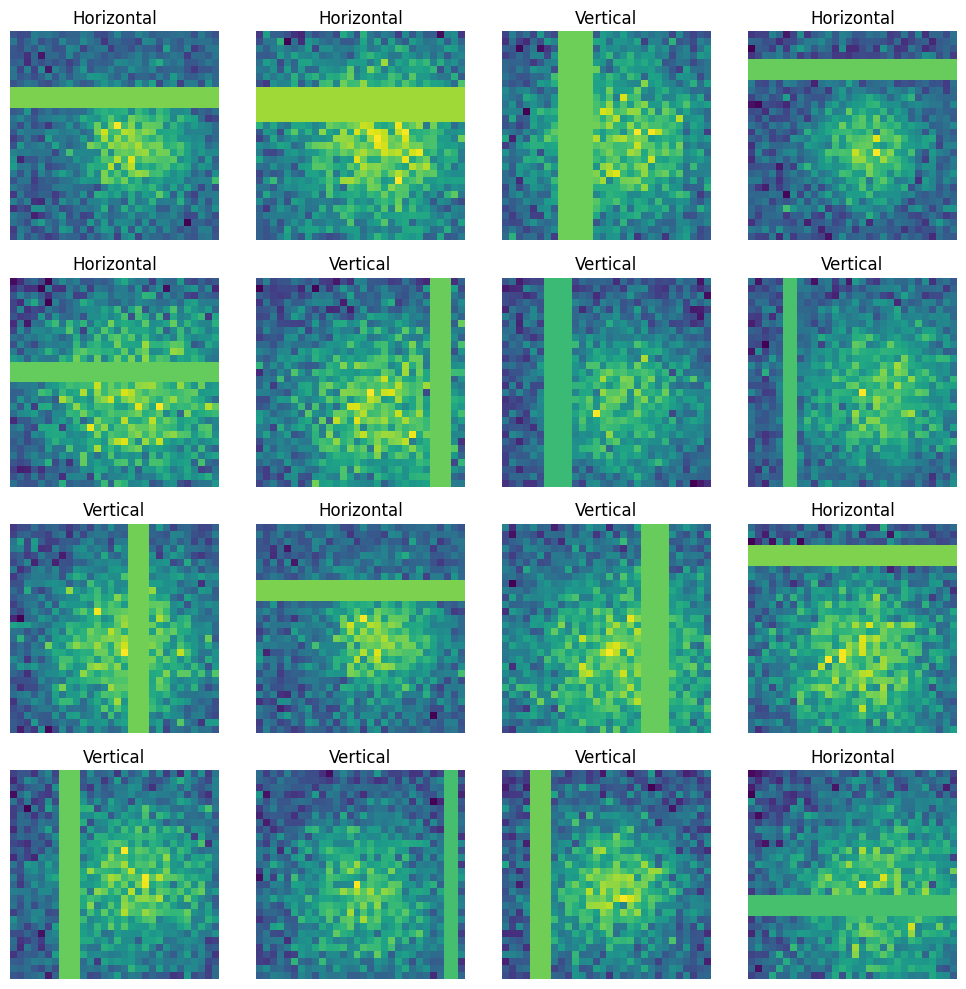

In [191]:
# create a list of random indices
idxList = np.random.choice(numberTrainImages, 16)

# plot a random sample of train images
fig, axs = plt.subplots(4,4,figsize=(10,10))

for i,ax in enumerate(axs.flatten()):
  ax.imshow(imagesTrain[idxList[i],:,:,:].view(imageSize,imageSize,1))
  ax.axis('off')

  # set title according to alignment of the bar
  if labelsTrain[idxList[i]]:
    ax.set_title('Vertical')
  else:
    ax.set_title('Horizontal')

plt.tight_layout()
plt.show()

## Create Test Images

In [192]:
numberImages = 100

#def createTestImages(numberImages):

# create an array of test images
testImagesMatrix = np.zeros((numberImages,1,30, 30), dtype=np.uint8)

# create a tensor that stores the labels
testLabelsEncoded = torch.zeros(numberImages,1)
testLabelsDecoded = []

# create an arry that store the slope for eaach image
slopeVector = np.zeros((numberImages))

# loop over the images
for i in range(numberImages):

  ## create a random integerbetween 0 and 29
  randomIntegers = np.random.randint(0, high=29,size=1)

  # pick an images
  img = testImagesMatrix[i,:,:,:]

  # create horizontal lines
  if i <= (numberImages/2):

    # initialize the cordinates for the line
    x_1 = 0
    x_2 = 29
    y_1 = randomIntegers[0]
    y_2 = x_2-y_1

    rr, cc, val = line_aa(y_1, x_1, y_2, x_2)

    img[0,rr, cc] = val * 100
    testImagesMatrix[i,:,:,:] = img

    # calculate and store the slope of the line
    slope = (29-y_1 -(y_1))/(x_2-x_1)
    slopeVector[i] = slope

  ## create vertical lines
  else:

    # initialize the cordinates for the line
    x_1 = randomIntegers[0]
    x_2 = 29-x_1
    y_1 = 29
    y_2 = 0

    rr, cc, val = line_aa(y_1, x_1, y_2, x_2)

    img[0,rr, cc] = val * 100
    testImagesMatrix[i,:,:,:] = img

    # calculate and store the slope of the line
    slope = ((29-y_1) -y_1)/(x_2-x_1)
    slopeVector[i] = slope

  # assign a label to each line according to the slope
  if (slopeVector[i]>-1) and (slopeVector[i]<1):
    testLabelsEncoded[i] = 0
    testLabelsDecoded.append('horz.')
  else:
    testLabelsEncoded[i] = 1
    testLabelsDecoded.append('vert.')


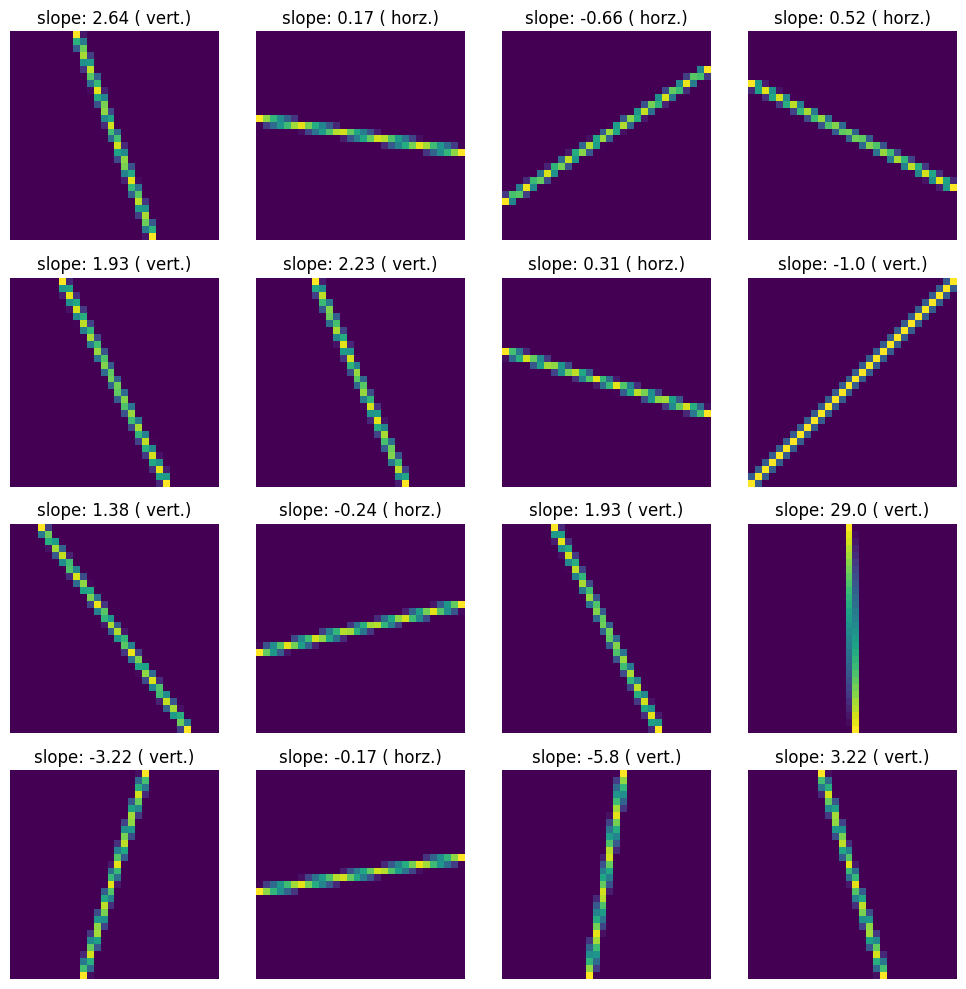

In [193]:
# For the sake of demostration, we are going to inspect some of the created test images

# create a list of random indices
idxList = np.random.choice(numberImages, 16, replace=False)

# plot the images
fig, axs = plt.subplots(4,4, figsize=(10,10))

# iterate of the number of images and plot each image
for (i,ax) in enumerate(axs.flatten()):
  idx = idxList[i]
  ax.imshow(testImagesMatrix[idx,:,:,:].transpose(1,2,0))
  ax.set_title('slope: ' +str(np.round(slopeVector[idx], decimals=2)) +' ( '+str(testLabelsDecoded[idx])+')')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [194]:
# Use sklearn to split the train data
train_data, test_data, train_labels, test_labels = train_test_split(imagesTrain, labelsTrain,test_size=0.2)

# convert the data in pytorch datasets
train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data, test_labels)

# convert them into pytorch dataloader objects
batchsize= 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

## Create the model

In [195]:
# Create a function that computes the output of the convolutional layer

def computeConvOutput(imagesizeW, imagesizeH, padding, k, s):

  # compute the width of the output image
  imagesizeW = np.floor(imagesizeW+2*padding-k[1]/s[1])+1
  imagesizeW = imagesizeW/2

  # compute the height of the output image
  imagesizeH = np.floor(imagesizeH+2*padding-k[0]/s[0])+1
  imagesizeH = imagesizeH/2

  return imagesizeW, imagesizeH


In [196]:
def createTheModel(padding, k, s, printtoggle):

  class cnnnet(nn.Module):
    def __init__(self):
      super().__init__()

      self.print = printtoggle

      # initialize imaga size
      imagesizeW = imageSize
      imagesizeH = imageSize

      ### convolutional layer

      # first convolutional layer
      self.conv1 = nn.Conv2d(1,10,kernel_size=k[0], stride=s[0], padding=padding)

      # calculate the output of the first convolutional layer
      imagesizeW, imagesizeH = computeConvOutput(imagesizeW, imagesizeH, padding, k, s)

      # second convolutional layer
      self.conv2 = nn.Conv2d(10,20,kernel_size=5, stride=1, padding=1)

       # calculate the output of the first convolutional layer
      imagesizeW, imagesizeH = computeConvOutput(imagesizeW, imagesizeH, padding, k, s)

      ### fully conected layer
      self.fc1 = nn.Linear(int(imagesizeW)*int(imagesizeH)*self.conv2.out_channels,50)
      self.out = nn.Linear(50,1) # We have only one outputlayer since we are using

    def forward(self,x):
      # first block: convolution -> maxpool -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(x)
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(x)
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel() / x.shape[0]
      x = x.view(-1, int(nUnits))
      if self.print: print(f'Vectorice: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = F.leaky_relu(self.out(x))
      if self.print: print(f'Vectorice: {list(x.shape)}')

      return x

  # create a model instance
  net = cnnnet()

  # lossfunction
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)

  return net, lossfun, optimizer


In [197]:
# test the model with one batch
padding = 1
k = (5,5)
s = (1,1)

net, lossfun, optimizer = createTheModel(padding, k, s, printtoggle=True)

X, y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nyHat shape:',yHat.shape)

# Now lets compute the loss
loss = lossfun(yHat,y)
print('\nloss:',loss.item())

First CPR block: [32, 10, 14, 14]
Second CPR block: [32, 20, 6, 6]
Vectorice: [32, 720]
Vectorice: [32, 1]

yHat shape: torch.Size([32, 1])

loss: 0.6931741237640381


## Create a Function that Trains the Model

In [198]:
def trainTheModel(padding, k, s, printtoggle,numepochs):

  # create a model
  net, lossfun, optimizer = createTheModel(padding, k, s, printtoggle)

  # initialze loss
  trainAcc= torch.zeros(numepochs)
  testAcc = torch.zeros(numepochs)
  trainLoss = torch.zeros(numepochs)
  testLoss= torch.zeros(numepochs)

  for epochi in range(numepochs):

    # switch to training mode
    net.train()
    batchLoss = []
    batchAcc = []

    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprob
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from that batch
      batchLoss.append(loss.item())

      # convert output to probability via sigmoid
      yy = torch.sigmoid(yHat)

      # convert thee output to probability via sigmoid
      acc = torch.mean(((yy>0.5).float().detach()==y).float())
      batchAcc.append(100*acc.item())
    # end of the batch

    # and get the avarage loss and accuracy rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi] = np.mean(batchAcc)

    # test performance
    net.eval()
    X,y = next(iter(test_loader))

    with torch.no_grad():
      yHat = net(X)
      loss = lossfun(yHat,y)

   # get the loss and the accuracy rate from the test batch
    testLoss[epochi] = np.mean(loss.item())

    yy = torch.sigmoid(yHat)
    testAcc[epochi] = 100*torch.mean(((yy>0.5).float().detach()==y).float()).item()

  # end epochs
  return trainLoss, trainAcc, testLoss, testAcc, net


## Run the Model

In [199]:
# initialize parameters
padding = 1
k = (5,5)
s = (1,1)
printtoggle=False

 # number of epochs
numepochs = 10

# run the model
trainLoss, trainAcc, testLoss, testAcc, net = trainTheModel(padding, k, s, printtoggle,numepochs)

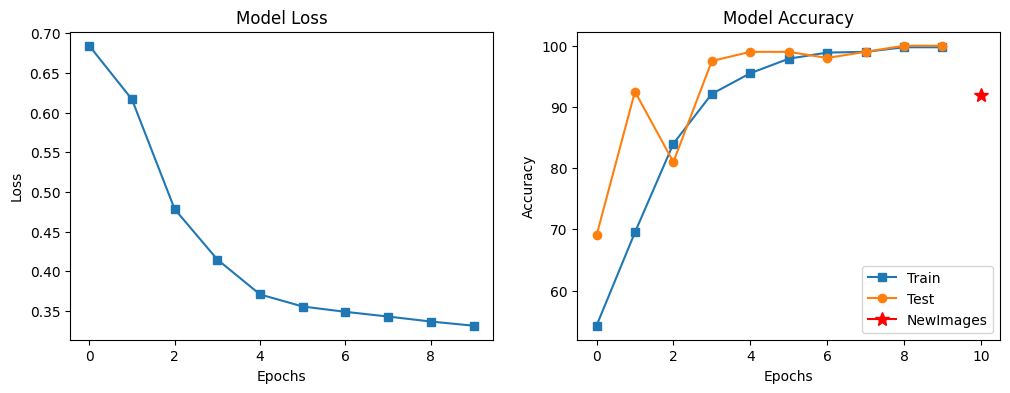

In [200]:
# Get the prediction
yHat = net(torch.tensor(testImagesMatrix).float())
yy = torch.sigmoid(yHat)

# Get the test image accuracy
testImagesAcc = 100*torch.mean(((yy>0.5).float().detach()==testLabelsEncoded).float()).item()

#plot the results
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(trainLoss, marker='s')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(trainAcc,marker='s', label='Train')
ax[1].plot(testAcc, marker='o', label='Test')
ax[1].plot(numepochs,testImagesAcc,marker='*', color='r', label='NewImages',markersize=10)
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

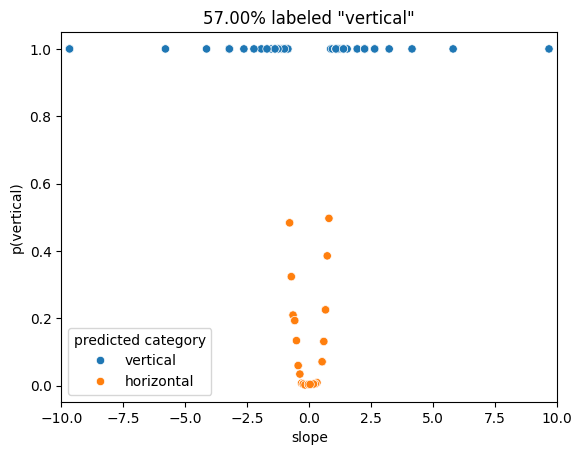

In [201]:
# Get the accuracy for the test images
testImagesAcc = 100*torch.mean(((yy>0.5).float().detach()==1).float()).item()
yyTransformed = torch.reshape(yy.detach(), (-1,)).numpy()

# Create a pandas dataframe
df = pd.DataFrame({'slope':slopeVector,'p(vertical)':yyTransformed})
df['predicted category']='horizontal'
df.loc[(df['p(vertical)'] == 1), 'predicted category'] = 'vertical'

# Use a scatterplott to visualize the results
sns.scatterplot(data=df, x="slope", y="p(vertical)", hue="predicted category")
plt.title('%.2f%% labeled "vertical"' %testImagesAcc)
plt.xlim([-10,10])
plt.show()

## Test the Model on new Images

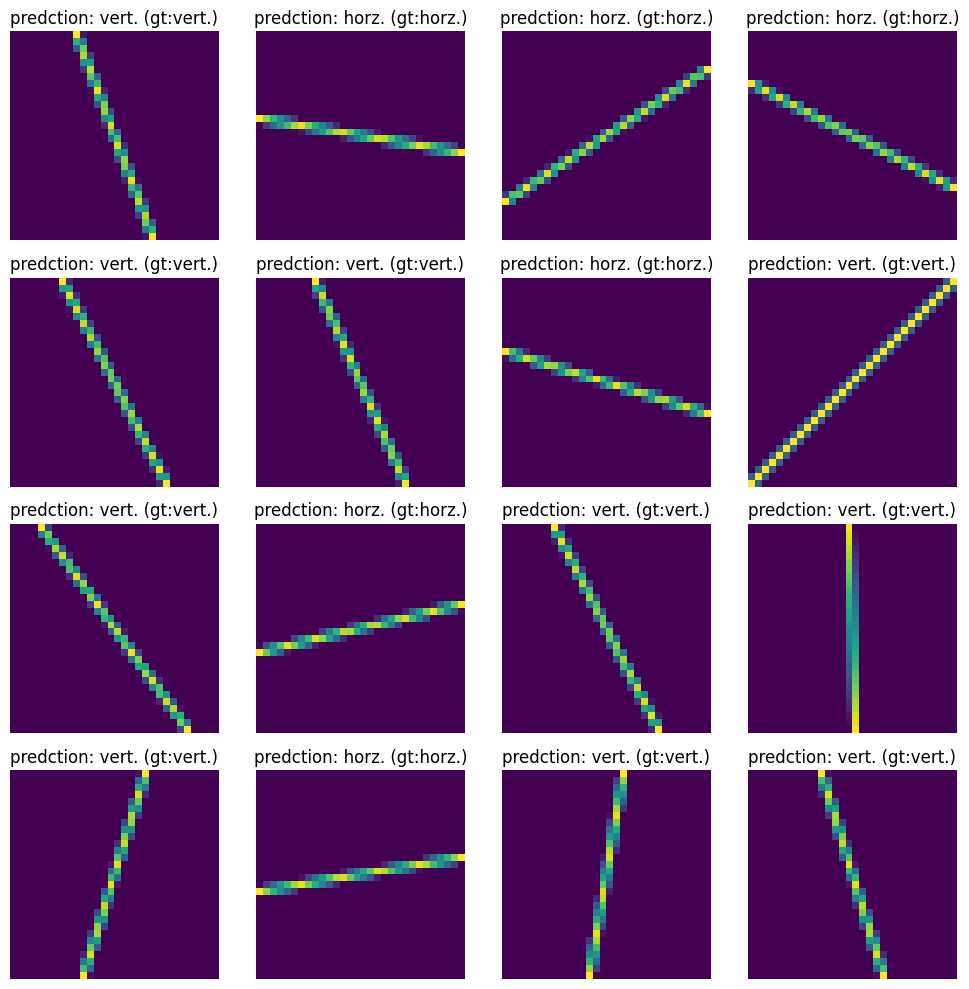

In [202]:
# initialize a list sto store the ecoded label
predictedLabel = []

# since the preddiction are encoded to 0 and 1, we need to decode them to horizontaal and vertical
for i in range(len(yy)):
  if yy[i]>0.5:
    predictedLabel.append('vert.')
  else:
    predictedLabel.append('horz.')

# plot the images
fig, axs = plt.subplots(4,4, figsize=(10,10))

# iterate of the number of images and plot each image
for (i,ax) in enumerate(axs.flatten()):
  idx = idxList[i]
  ax.imshow(testImagesMatrix[idx,:,:,:].transpose(1,2,0))
  ax.set_title('predction: ' +predictedLabel[idx] +' (gt:'+str(testLabelsDecoded[idx])+')') # print the predicted label together with its ground truth (gt) label in the image title
  ax.axis('off')

plt.tight_layout()
plt.show()

## References:

https://www.udemy.com/course/deeplearning_x/